In [1]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

df = pd.read_csv('/Users/apple/Desktop/1030_sem_project/mxmh_survey_results.csv')
df = df.drop('Permissions', axis = 1)
df = df.drop('Timestamp', axis = 1)
#df = df.drop('BPM', axis = 1)
df['Anxiety'] = df['Anxiety'].astype(int)
print(df['Anxiety'].unique())

# let's separate the feature matrix X, and target variable y
y = df['Anxiety'] # remember, we want to predict who earns more than 50k or less than 50k
X = df.loc[:, df.columns != 'Anxiety'] # all other columns are features

# collect which encoder to use on each feature
# needs to be done manually
ordinal_ftrs = ['Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]', \
               'Frequency [Hip hop]','Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', \
               'Frequency [Metal]', 'Frequency [Pop]','Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', \
               'Frequency [Video game music]', 'Depression', 'Insomnia','OCD']

ordinal_cats = [['Never','Rarely','Sometimes','Very frequently'],['Never','Rarely','Sometimes','Very frequently'],\
                ['Never','Rarely','Sometimes','Very frequently'],['Never','Rarely','Sometimes','Very frequently'],\
                ['Never','Rarely','Sometimes','Very frequently'],['Never','Rarely','Sometimes','Very frequently'],\
                ['Never','Rarely','Sometimes','Very frequently'],['Never','Rarely','Sometimes','Very frequently'],\
                ['Never','Rarely','Sometimes','Very frequently'],['Never','Rarely','Sometimes','Very frequently'],\
                ['Never','Rarely','Sometimes','Very frequently'],['Never','Rarely','Sometimes','Very frequently'],\
                ['Never','Rarely','Sometimes','Very frequently'],['Never','Rarely','Sometimes','Very frequently'],\
                ['Never','Rarely','Sometimes','Very frequently'],['Never','Rarely','Sometimes','Very frequently'],\
                [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10],
                [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10],
                [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]]

onehot_ftrs = ['Primary streaming service','While working', 'Instrumentalist', 'Composer', 'Fav genre', \
                   'Exploratory', 'Foreign languages', 'Music effects']

std_ftrs = ['Age', 'Hours per day','BPM'] #BPM

# collect all the encoders into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])
imputer = IterativeImputer(estimator = XGBRegressor(n_estimators=1), random_state=42)
prep = Pipeline(steps=[('preprocessor', preprocessor)])

[ 3  7  9  8  4  5  2  1  6 10  0]


(736, 31)

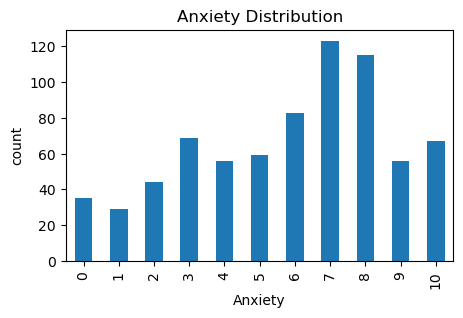

In [105]:
import matplotlib
import numpy as np
from matplotlib import pylab as plt

plt.figure(figsize=(5,3))
value_counts = pd.value_counts(df['Anxiety'])
value_counts.sort_index().plot.bar()
plt.ylabel('count')
plt.xlabel('Anxiety')
plt.title('Anxiety Distribution')
plt.show()

In [106]:
#random forest
param_grid = {
              'randomforestclassifier__max_depth': [1, 3, 10, 30, 100], # the max_depth should be smaller or equal than the number of features roughly
              'randomforestclassifier__max_features': [0.5,0.75,1.0] # linearly spaced between 0.5 and 1
              } 

random_state =42
final_models = []
test_scores = []
# first split to separate out the test set
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
print(X_other.shape,y_other.shape)
print('test set:',X_test.shape,y_test.shape)

# do KFold split on other
kf = KFold(n_splits=5,shuffle=True,random_state=random_state)
# for train_index, val_index in kf.split(X_other,y_other):
#     X_train = X_other.iloc[train_index]
#     y_train = y_other.iloc[train_index]
#     X_val = X_other.iloc[val_index]
#     y_val = y_other.iloc[val_index]
#     print('   training set:',X_train.shape, y_train.shape) 
#     print('   validation set:',X_val.shape, y_val.shape) 

    # X_train_prep = prep.fit_transform(X_train)
    # X_val_prep = prep.transform(X_val)
    # X_test_prep = prep.transform(X_test)
    # feature_names = prep.get_feature_names_out()

    # df_train = pd.DataFrame(data=X_train_prep,columns=feature_names)
    # print(df_train.shape)
    
    # # transform the CV
    # df_CV = pd.DataFrame(data=X_val_prep,columns = feature_names)
    # print(df_CV.shape)
    
    # # transform the test
    # df_test = pd.DataFrame(data=X_test_prep,columns = feature_names)
    # print(df_test.shape)

    #imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
    # X_impute = imputer.fit_transform(df_train)
    # df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)
    # df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
    # df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

clf = RandomForestClassifier(random_state = random_state) 
pipe = make_pipeline(preprocessor, imputer, clf)
    
grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                    cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        
# this line actually fits the model on other
grid.fit(X_other, y_other)
# save results into a data frame. feel free to print it and inspect it
results = pd.DataFrame(grid.cv_results_)
#print(results)
    
print('best model parameters:',grid.best_params_)
print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
# save the model
final_models.append(grid)
# calculate and save the test score
y_test_pred = list(map(int, final_models[-1].predict(X_test)))
#print(y_test_pred)
test_scores.append(accuracy_score(list(map(int, y_test)),y_test_pred))
print('test score:',test_scores[-1])

(588, 30) (588,)
test set: (148, 30) (148,)
Fitting 5 folds for each of 15 candidates, totalling 75 fits
best model parameters: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.75}
validation score: 0.2329566854990584
test score: 0.1891891891891892


(-1.0, 11.0)

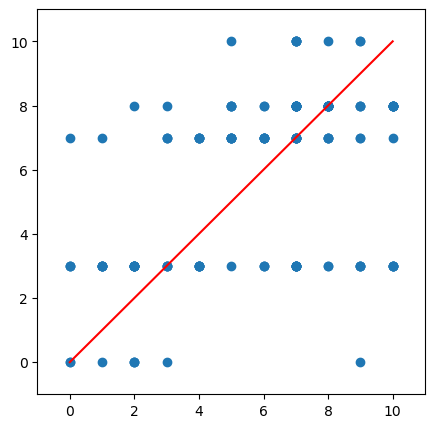

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred)
plt.plot((0, 10), (0, 10), c='red')
plt.xlim(-1, 11)
plt.ylim(-1, 11)

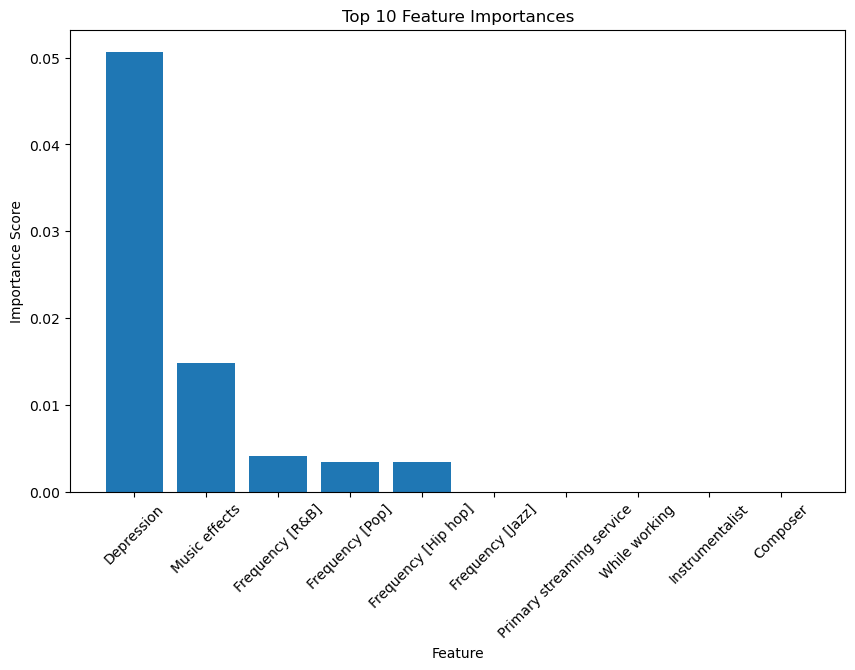

In [107]:
#Feature Importance for Random Forest
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

result = permutation_importance(grid, X_test, y_test, n_repeats=10,random_state=0)
result

importances = result.importances_mean
indices = np.argsort(importances)[::-1]

#Get top 10
top_features = 10
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(top_features), importances[indices][:top_features], align="center")
plt.xticks(range(top_features), X_test.columns[indices][:top_features], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [ ]:
#df_train.isnull().sum().to_frame().rename(columns={0:'null_count'}).sort_values(by='null_count', ascending=False).T

In [46]:
#logistic regression
from sklearn.linear_model import LogisticRegression
param_grid = {
              'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
              } 

random_state =42
final_models = []
test_scores = []
# first split to separate out the test set
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
print(X_other.shape,y_other.shape)
print('test set:',X_test.shape,y_test.shape)

# do KFold split on other
kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

clf = LogisticRegression(random_state = random_state, max_iter=1000000000) 
pipe = make_pipeline(preprocessor, imputer, clf)
    
grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                    cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        
# this line actually fits the model on other
grid.fit(X_other, y_other)
# save results into a data frame. feel free to print it and inspect it
results = pd.DataFrame(grid.cv_results_)
#print(results)
    
print('best model parameters:',grid.best_params_)
print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
# save the model
final_models.append(grid)
# calculate and save the test score
y_test_pred = list(map(int, final_models[-1].predict(X_test)))
#print(y_test_pred)
test_scores.append(accuracy_score(list(map(int, y_test)),y_test_pred))
print('test score:',test_scores[-1])

(588, 30) (588,)
test set: (148, 30) (148,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'logisticregression__C': 0.1}
validation score: 0.21421121251629724
test score: 0.17567567567567569


In [47]:
#Feature Importance for Random Forest
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

result = permutation_importance(grid, X_test, y_test, n_repeats=10,random_state=0)
result


{'importances_mean': array([-0.00405405,  0.00337838,  0.01824324,  0.00810811, -0.00878378,
         0.01283784,  0.02094595,  0.01013514,  0.00810811,  0.00675676,
        -0.00608108, -0.00608108, -0.00878378, -0.01013514, -0.00202703,
         0.00067568,  0.00675676,  0.03378378,  0.00608108,  0.00945946,
         0.025     ,  0.00878378,  0.00405405,  0.01486486,  0.00067568,
         0.02094595,  0.04189189,  0.02905405,  0.03378378, -0.00675676]),
 'importances_std': array([0.00865287, 0.01218092, 0.00909029, 0.01410852, 0.01091587,
        0.00637431, 0.01332641, 0.00622942, 0.01621622, 0.00427335,
        0.01721316, 0.01554054, 0.01283784, 0.01325771, 0.01283784,
        0.0076742 , 0.00906514, 0.01449163, 0.00637431, 0.01324049,
        0.01571582, 0.00909029, 0.01055439, 0.00993036, 0.01431731,
        0.00824767, 0.01274862, 0.01318866, 0.01317134, 0.01089494]),
 'importances': array([[-0.00675676,  0.        , -0.01351351, -0.00675676, -0.02027027,
         -0.00675676, 

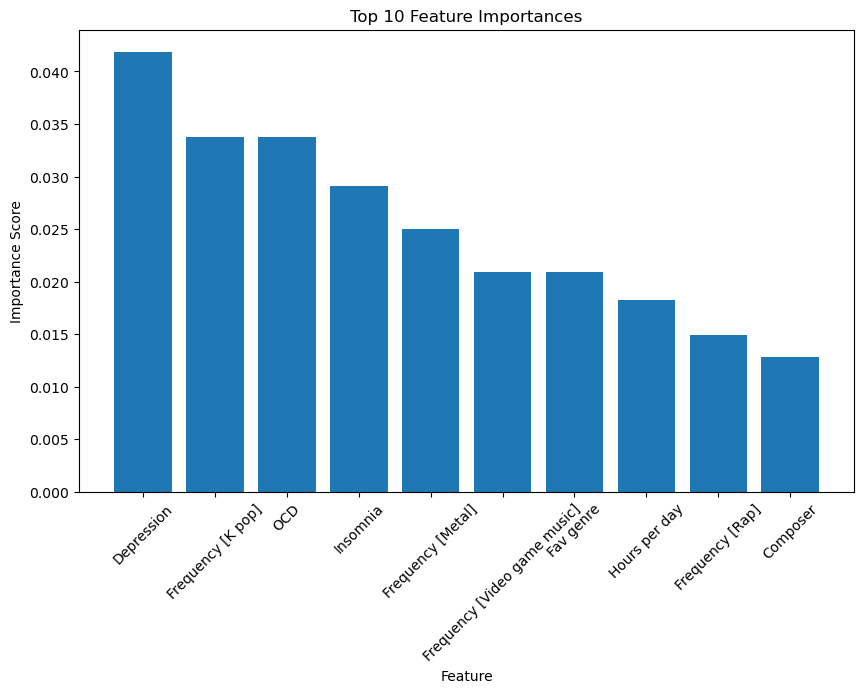

In [48]:
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

#Get top 10
top_features = 10
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(top_features), importances[indices][:top_features], align="center")
plt.xticks(range(top_features), X_test.columns[indices][:top_features], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [55]:
#SVM
from sklearn.svm import SVC
param_grid = {
              'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']
              } 

random_state =42
final_models = []
test_scores = []
# first split to separate out the test set
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
print(X_other.shape,y_other.shape)
print('test set:',X_test.shape,y_test.shape)

# do KFold split on other
kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

clf = SVC(random_state = random_state, max_iter=1000000000) 
pipe = make_pipeline(preprocessor, imputer, clf)
    
grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                    cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        
# this line actually fits the model on other
grid.fit(X_other, y_other)
# save results into a data frame. feel free to print it and inspect it
results = pd.DataFrame(grid.cv_results_)
#print(results)
    
print('best model parameters:',grid.best_params_)
print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
# save the model
final_models.append(grid)
# calculate and save the test score
y_test_pred = list(map(int, final_models[-1].predict(X_test)))
#print(y_test_pred)
test_scores.append(accuracy_score(list(map(int, y_test)),y_test_pred))
print('test score:',test_scores[-1])

(588, 30) (588,)
test set: (148, 30) (148,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'svc__C': 1, 'svc__kernel': 'rbf'}
validation score: 0.22622048384760246
test score: 0.16216216216216217


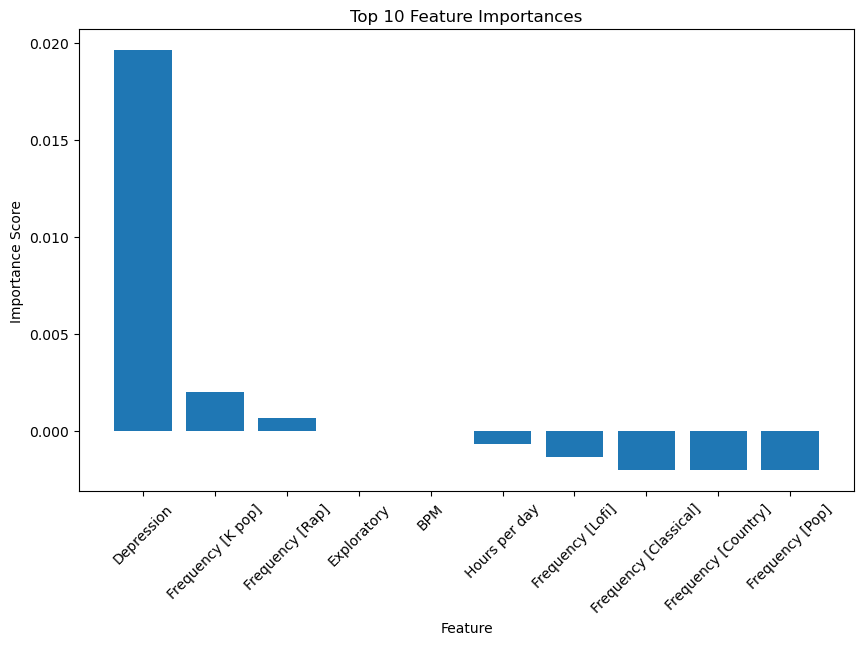

In [50]:
#Feature Importance for SVM
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

result = permutation_importance(grid, X_test, y_test, n_repeats=10,random_state=0)
result

importances = result.importances_mean
indices = np.argsort(importances)[::-1]

#Get top 10
top_features = 10
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(top_features), importances[indices][:top_features], align="center")
plt.xticks(range(top_features), X_test.columns[indices][:top_features], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [90]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

param_grid = {
              'kneighborsclassifier__n_neighbors': [30, 50, 70]
              } 

random_state =42
final_models = []
test_scores = []
# first split to separate out the test set
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
print(X_other.shape,y_other.shape)
print('test set:',X_test.shape,y_test.shape)

clf = KNeighborsClassifier()#random_state = random_state, max_iter=1000000000) 
pipe = make_pipeline(preprocessor, imputer, clf)
    
grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                    cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        
# this line actually fits the model on other
grid.fit(X_other, y_other)
# save results into a data frame. feel free to print it and inspect it
results = pd.DataFrame(grid.cv_results_)
#print(results)
    
print('best model parameters:',grid.best_params_)
print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
# save the model
final_models.append(grid)
# calculate and save the test score
y_test_pred = list(map(int, final_models[-1].predict(X_test)))
#print(y_test_pred)
test_scores.append(accuracy_score(list(map(int, y_test)),y_test_pred))
print('test score:',test_scores[-1])

(588, 30) (588,)
test set: (148, 30) (148,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'kneighborsclassifier__n_neighbors': 50}
validation score: 0.2211067651745618
test score: 0.21621621621621623


In [91]:
#Feature Importance of KNN

In [92]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

result = permutation_importance(grid, X_test, y_test, n_repeats=10,random_state=0)
result

{'importances_mean': array([ 1.75675676e-02,  7.43243243e-03,  1.55405405e-02, -3.37837838e-03,
         6.75675676e-04,  3.37837838e-03,  3.37837838e-03,  4.72972973e-03,
        -4.72972973e-03,  0.00000000e+00,  5.55111512e-18,  1.35135135e-03,
        -8.10810811e-03,  1.11022302e-17,  8.10810811e-03,  2.70270270e-03,
        -5.40540541e-03, -2.02702703e-02, -6.75675676e-03, -4.05405405e-03,
         1.35135135e-03,  1.01351351e-02, -2.02702703e-03,  8.10810811e-03,
        -5.40540541e-03, -3.37837838e-03,  4.72972973e-02, -1.75675676e-02,
         2.97297297e-02,  6.08108108e-03]),
 'importances_std': array([0.00810811, 0.00472973, 0.00857336, 0.00544747, 0.00472973,
        0.00337838, 0.00453257, 0.0052772 , 0.00432644, 0.        ,
        0.0095555 , 0.00787966, 0.00945946, 0.0095555 , 0.00405405,
        0.01011259, 0.01122517, 0.01282004, 0.00740166, 0.01055439,
        0.00896385, 0.00813621, 0.00608108, 0.00993036, 0.00993036,
        0.00813621, 0.02027027, 0.01767121, 0

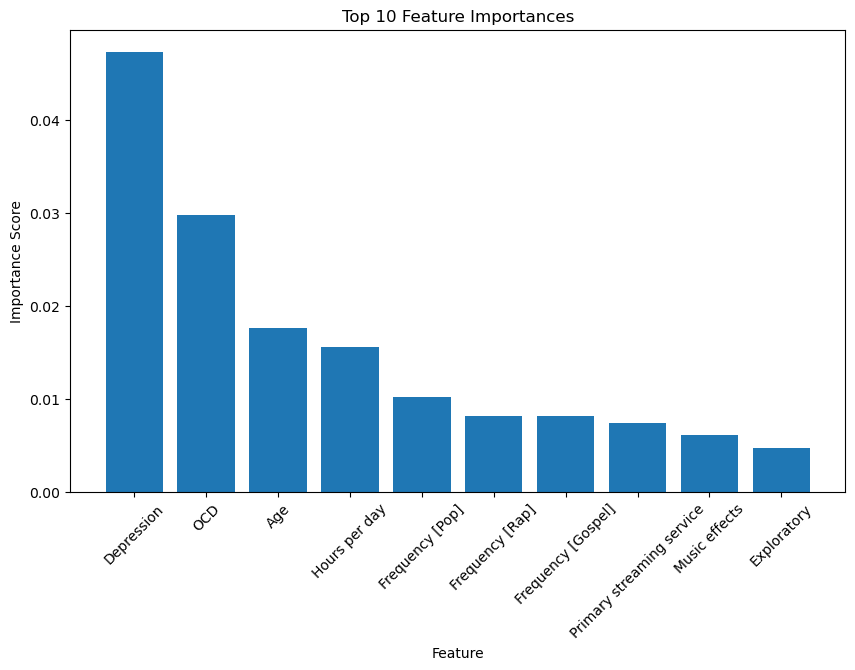

In [93]:
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

#Get top 10
top_features = 10
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(top_features), importances[indices][:top_features], align="center")
plt.xticks(range(top_features), X_test.columns[indices][:top_features], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [108]:
#XGB
import xgboost

kf = KFold(n_splits=5,shuffle=True,random_state=random_state)

param_grid = {"xgbclassifier__learning_rate": [0.03],
              "xgbclassifier__n_estimators": [50],
              "xgbclassifier__seed": [0],
              "xgbclassifier__max_depth": [1, 3, 10],
              "xgbclassifier__missing": [np.nan], 
              "xgbclassifier__colsample_bytree": [0.9],              
              "xgbclassifier__subsample": [0.66]}

random_state =42
final_models = []
test_scores = []
# first split to separate out the test set
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
print(X_other.shape,y_other.shape)
print('test set:',X_test.shape,y_test.shape)

clf =  xgboost.XGBClassifier()#random_state = random_state, max_iter=1000000000) 
pipe = make_pipeline(preprocessor, clf)
    
grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                    cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        
# this line actually fits the model on other
grid.fit(X_other, y_other)
# save results into a data frame. feel free to print it and inspect it
results = pd.DataFrame(grid.cv_results_)
#print(results)
    
print('best model parameters:',grid.best_params_)
print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
# save the model
final_models.append(grid)
# calculate and save the test score
y_test_pred = list(map(int, final_models[-1].predict(X_test)))
#print(y_test_pred)
test_scores.append(accuracy_score(list(map(int, y_test)),y_test_pred))
print('test score:',test_scores[-1])

(588, 30) (588,)
test set: (148, 30) (148,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best model parameters: {'xgbclassifier__colsample_bytree': 0.9, 'xgbclassifier__learning_rate': 0.03, 'xgbclassifier__max_depth': 1, 'xgbclassifier__missing': nan, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__seed': 0, 'xgbclassifier__subsample': 0.66}
validation score: 0.19213385484571927
test score: 0.17567567567567569


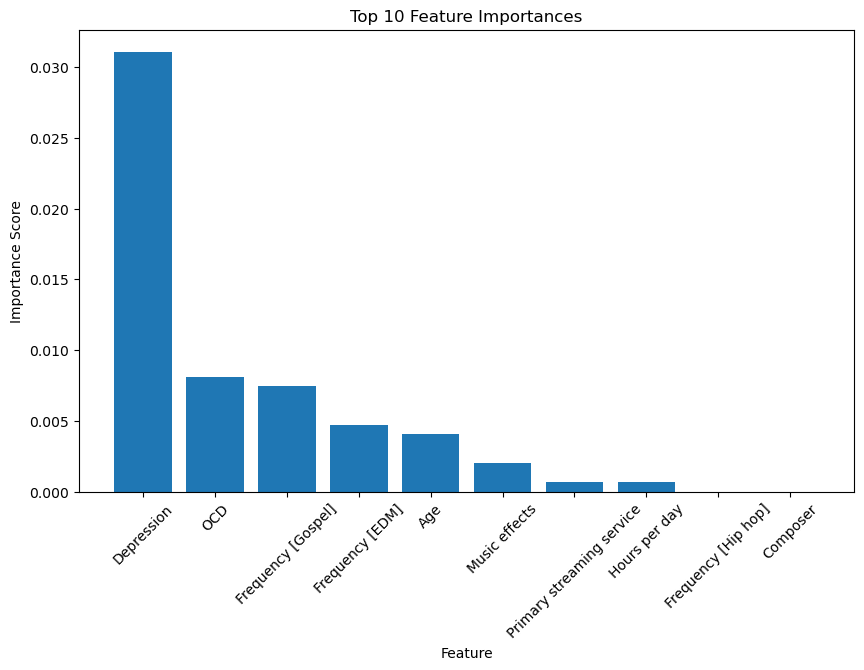

In [109]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

result = permutation_importance(grid, X_test, y_test, n_repeats=10,random_state=0)
result

importances = result.importances_mean
indices = np.argsort(importances)[::-1]

#Get top 10
top_features = 10
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(top_features), importances[indices][:top_features], align="center")
plt.xticks(range(top_features), X_test.columns[indices][:top_features], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [ ]:
#2nd feature importance

In [ ]:
#3rd feature importance

(-1.0, 11.0)

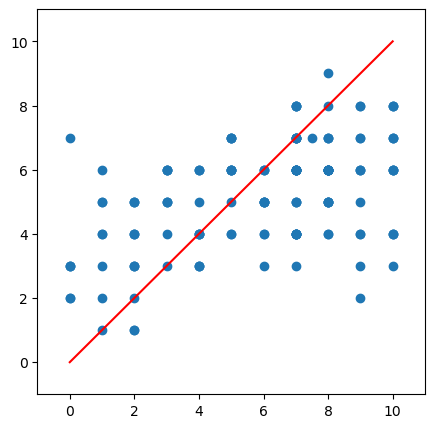

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred)
plt.plot((0, 10), (0, 10), c='red')
plt.xlim(-1, 11)
plt.ylim(-1, 11)